# Coin flip on global Pauli error model for QRBM

In [1]:
import pyquil.api as api
from pyquil import Program
from qRBM_final import qRBM
from pyquil.gates import *
from random import *
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss 

## Utility functions

In [70]:
def train(num_epochs=20, gate_noise_probs=None, meas_noise_probs=None, n_quantum_measurements=None):
    '''
    gate_noise_probs:       PX, PY, PZ gates getting applied to each qubit after every gate application
    meas_noise_probs:       PX, PY, PZ gates getting applied to the qubit being measured before it is measured
    n_quantum_measurements: None means "analytical" measurement to save time on simulation

    '''
    qvm = api.QVMConnection(gate_noise=gate_noise_probs, measurement_noise=meas_noise_probs)
    qr = qRBM(qvm, num_visible=4, num_hidden=1, n_quantum_measurements=n_quantum_measurements)
    qr.train(artificial_data, n_epochs=num_epochs)
    return qr, max_prob_list(qr.pred_list)

In [71]:
def max_prob_list(pred_list):
    max_prob_list = []
    for epoch_pred in pred_list:
        max_prob_list.append(np.max(epoch_pred))
    return max_prob_list

In [31]:
def get_log_loss_list(qr, num_epochs):
    log_loss_list = []
    for epoch in range(num_epochs):
        log_loss_list.append(log_loss(random_coin, qr.pred_list[epoch], eps=1e-15))
    return log_loss_list

In [119]:
def plot_loss(log_loss_list):
    plt.plot(log_loss_list)
    # plt.ylim(0, 1)
    plt.xlabel('epochs')
    plt.ylabel('Probability')
    plt.title('Probability across epochs') 

In [40]:
def show_probs(qr):
    transformed = qr.transform(artificial_data)

    comparison = np.stack((transformed[:,0]
                           , random_coin))

    #compare our rbm probabilities with the coin flips.
    print('RBM Pr. | Original Coin Value')
    # print '-'*20
    for i in range(len(transformed)):
        print('{: 0.3f}'.format(float(comparison[:,i][0])), ' |', '{: 0.3f}'.format(comparison[:,i][1]))

In [121]:
def plot_prob_lists(prob_list, noise_probs_list, noise_type='gate'):
    fig, ax = plt.subplots(figsize=(10,6))
    for epoch, prob in enumerate(prob_list):
        ax.plot(prob, label=noise_probs_list[epoch], marker=epoch+6)
    ax.legend()
    ax.set_title('Probabilities for different ' + noise_type + ' noise settings')

In [104]:
def evaluate_noise(num_epochs, n_quantum_measurements, noise_probs_list, noise_type='gate', ):
    prob_list = []
    model_list = []
    for noise_probs in noise_probs_list:
        if noise_type == 'gate':
            model, prob = train(num_epochs=num_epochs, 
                                     gate_noise_probs=noise_probs,
                                     n_quantum_measurements=n_quantum_measurements)
        if noise_type == 'meas':
            model, prob = train(num_epochs=num_epochs, 
                                     meas_noise_probs=noise_probs,
                                     n_quantum_measurements=n_quantum_measurements)
            
        prob_list.append(prob)
        model_list.append(model)
    return prob_list, model_list

## Creating the underlying distribution
We flip an unbiased coin to generate a sequence of random bits, this will be the underlying hidden distribution of our data.

In [35]:
#flip a coin
np.random.seed(1234)
random_coin = np.random.choice([0,1], size=20, replace=True)
random_coin

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])

## Generating encoded sequences
Code below takes our sequence of random bits and encodes each 1 bit result into a 4 bit representation. This effectively creates artificial data with a 1 bit "needle" (hidden code subspace) in the "haystack" (4-bit data), which our RBM will have to decode. 

In [36]:
#Encode this coin flip in to an artifically high dimensional dataset
artificial_data = []
for flip in random_coin:
    if flip == 1:
        artificial_data.append([-1,-1,1,1]) 
    else:
        artificial_data.append([1,1,-1,-1]) 

#We know have an artificially high dimensional dataset that still only has the 1 bit coin flip dictating
#the underlying distribution
artificial_data = np.asarray(artificial_data)
artificial_data.shape

(20, 4)

# Experiement parameters

In [94]:
num_epochs = 10
n_quantum_measurements = 5

# Noiseless QVM

In [114]:
%%capture
model, prob_list = train(num_epochs=num_epochs, n_quantum_measurements=n_quantum_measurements,)

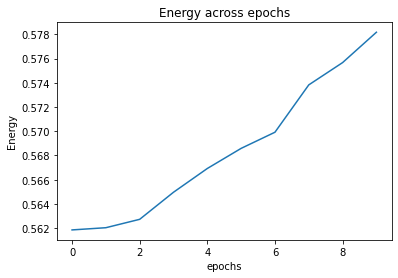

In [115]:
plot_loss(prob_list)

# QVM gate noise

In [130]:
gate_noise_probs_list = [[0.0, 0.0, 0.0],
                         [0.2, 0.0, 0.0],
                        [0.0, 0.2, 0.0],
                        [0.0, 0.0, 0.2],
                        [0.2, 0.2, 0.2],]

In [131]:
%%capture
gate_prob_list, gate_model_list = evaluate_noise(num_epochs, 
                                       n_quantum_measurements, 
                                       gate_noise_probs_list,
                                      noise_type='gate')

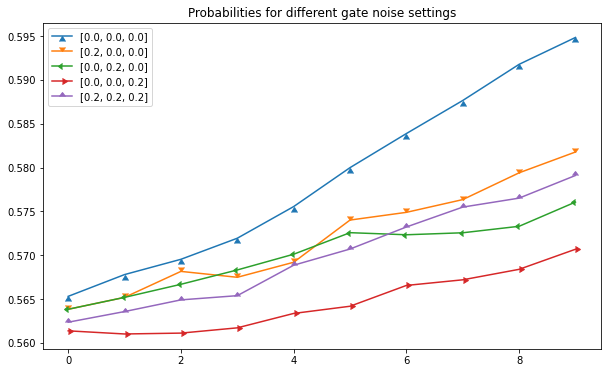

In [132]:
plot_prob_lists(gate_prob_list, gate_noise_probs_list, noise_type='gate')

# QVM measurement noise

In [116]:
measurement_noise_probs_list = [[0.0, 0.0, 0.0],
                         [0.2, 0.0, 0.0],
                        [0.0, 0.2, 0.0],
                        [0.0, 0.0, 0.2],
                        [0.2, 0.2, 0.2],]

In [117]:
%%capture
meas_prob_list, meas_model_list = evaluate_noise(num_epochs, 
                                       n_quantum_measurements, 
                                       measurement_noise_probs_list,
                                      noise_type='meas')

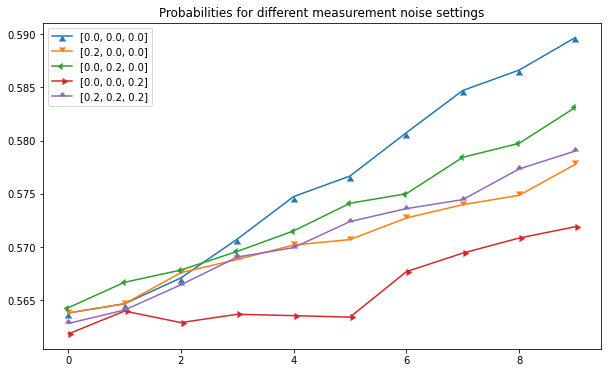

In [126]:
plot_prob_lists(meas_prob_list, measurement_noise_probs_list, noise_type='measurement')